In [1]:
import warnings
notebook_warnings = []
def warning_collector(message, category, filename, lineno, file=None, line=None):
    notebook_warnings.append(f"{category.__name__}: {message} (File {filename}, line {lineno})")
warnings.showwarning = warning_collector


In [2]:
# -*- coding: utf-8 -*-
#  Copyright 2025 United Kingdom Research and Innovation
#  Copyright 2025 The University of Manchester
#  Copyright 2025 Technical University of Denmark
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.
#
#   Authored by:    Hannah Robarts (UKRI-STFC)
#                   Laura Murgatroyd (UKRI-STFC)

# CIL-ESRF pipeline

This notebook contains example scripts for loading, pre-processing, reconstructing and visualising tomography data collected at ESRF beamlines. The steps are designed to be adaptable for different kinds of synchrotron datasets and covers commonly used methods, including:
- Extracting experiment information and configuring a CIL `AcquisitionData` object
- Applying CIL pre-processors, including `Normaliser`, `TransmissionAbsorptionConverter`, `CentreOfRotationCorrector` and `PaganinProcessor`
- Reconstructing using filtered back projection with CIL's wrapper for tigre

This example uses dataset tomo_00065 from the TomoBank [[1](https://iopscience.iop.org/article/10.1088/1361-6501/aa9c19)] multidistance dataset. The sample is a steel sphere measured at various propagation distances to demonstrate the effect of propagation based phase contrast imaging.

The tomo_00065.h5 dataset can be retrieved from https://tomobank.readthedocs.io/en/latest/source/data/docs.data.phasecontrast.html#multi-distance using:

`wget https://g-a0400.fd635.8443.data.globus.org/tomo_00064_to_00067/tomo_00065.h5`

[1] De Carlo, Francesco, et al. “TomoBank: a tomographic data repository for computational x-ray science.” Measurement Science and Technology 29.3 (2018): 034004. http://www.doi.org/10.1088/1361-6501/aa9c19

##### Load dependencies

In [3]:
# CIL methods
from cil.framework import DataContainer
from cil.utilities.display import show2D, show_geometry
from cil.utilities.jupyter import islicer
from cil.io.utilities import HDF5_utilities
from cil.io import TIFFWriter
from cil.processors import Normaliser, RingRemover, TransmissionAbsorptionConverter, CentreOfRotationCorrector, PaganinProcessor
from cil.recon import FBP
# Additional packages
import numpy as np # conda install numpy
import matplotlib.pyplot as plt # conda install matplotlib
# Custom methods
from esrf_code.HDF5_ParallelDataReader import HDF5_ParallelDataReader


##### Load the data

Choose the file and use `HDF5_utilities` to print the metadata and find the locations of data and scan information within the file. We see there is a lot of information about the experiment we can use to help with the processing and reconstruction

In [4]:
filename = '/mnt/share/materials/SIRF/Fully3D/CIL/Phase/tomo_00065.h5'
HDF5_utilities.print_metadata(filename) # comment out if you don't want to see the metadata

	 - exchange : <HDF5 group "/exchange" (5 members)>
		 - data : <HDF5 dataset "data": shape (450, 650, 350), type "<u2">
				 - axes : theta:y:x
				 - description : transmission
				 - units : counts
		 - data_dark : <HDF5 dataset "data_dark": shape (2, 650, 350), type "<u2">
				 - axes : theta_dark:y:x
				 - units : counts
		 - data_white : <HDF5 dataset "data_white": shape (4, 650, 350), type "<u2">
				 - axes : theta_white:y:x
				 - units : counts
		 - theta : <HDF5 dataset "theta": shape (450,), type "<f8">
				 - units : degrees
		 - title : <HDF5 dataset "title": shape (), type "|O">
	 - implements : <HDF5 dataset "implements": shape (), type "|O">
	 - measurement : <HDF5 group "/measurement" (2 members)>
		 - instrument : <HDF5 group "/measurement/instrument" (4 members)>
			 - acquisition : <HDF5 group "/measurement/instrument/acquisition" (2 members)>
				 - comment : <HDF5 dataset "comment": shape (), type "|O">
				 - mode : <HDF5 dataset "mode": shape (), type "|O">
		

Configure paths to the relevant data and metadata in the file, then read the data using the generic `HDF5_ParallelDataReader`


In [5]:
reader = HDF5_ParallelDataReader(filename, 
                                 dataset_path=('exchange/data'),
                                 distance_units='mm', angle_units='degree')

reader.configure_angles(angles_path='exchange/theta', HDF5_units='degree')

reader.configure_pixel_sizes('measurement/instrument/detector/x_actual_pixel_size',
                             'measurement/instrument/detector/y_actual_pixel_size',
                             HDF5_units = 'um')

reader.configure_normalisation_data(flatfield_path='exchange/data_white',
                                    darkfield_path='exchange/data_dark')

reader.configure_sample_detector_distance(sample_detector_distance=58, HDF5_units='mm') # required for phase retrieval

data = reader.read()

energy = HDF5_utilities.read(filename, 'measurement/instrument/monochromator/energy') # required for phase retrieval

New geometry:  3D Parallel-beam tomography
System configuration:
	Ray direction: [0., 1., 0.]
	Rotation axis position: [0., 0., 0.]
	Rotation axis direction: [0., 0., 1.]
	Detector position: [ 0., 58.,  0.]
	Detector direction x: [1., 0., 0.]
	Detector direction y: [0., 0., 1.]
Panel configuration:
	Number of pixels: [350 650]
	Pixel size: [0.0499 0.0499]
	Pixel origin: bottom-left
Channel configuration:
	Number of channels: 1
Acquisition description:
	Number of positions: 450
	Angles 0-9 in degrees: [0. , 0.8, 1.6, 2.4, 3.2, 4. , 4.8, 5.6, 6.4, 7.2]
	Angles 440-449 in degrees: [352. , 352.8, 353.6, 354.4, 355.2, 356. , 356.8, 357.6, 358.4, 359.2]
	Full angular array can be accessed with acquisition_data.geometry.angles
Distances in units: mm
Shape out:  (450, 650, 350)


Use `islicer` to visualise the data. Try looking through the projections by sliding the slice index slider.

In [6]:
islicer(data)

And `show_geometry()` to check the orientation of the sample and detector

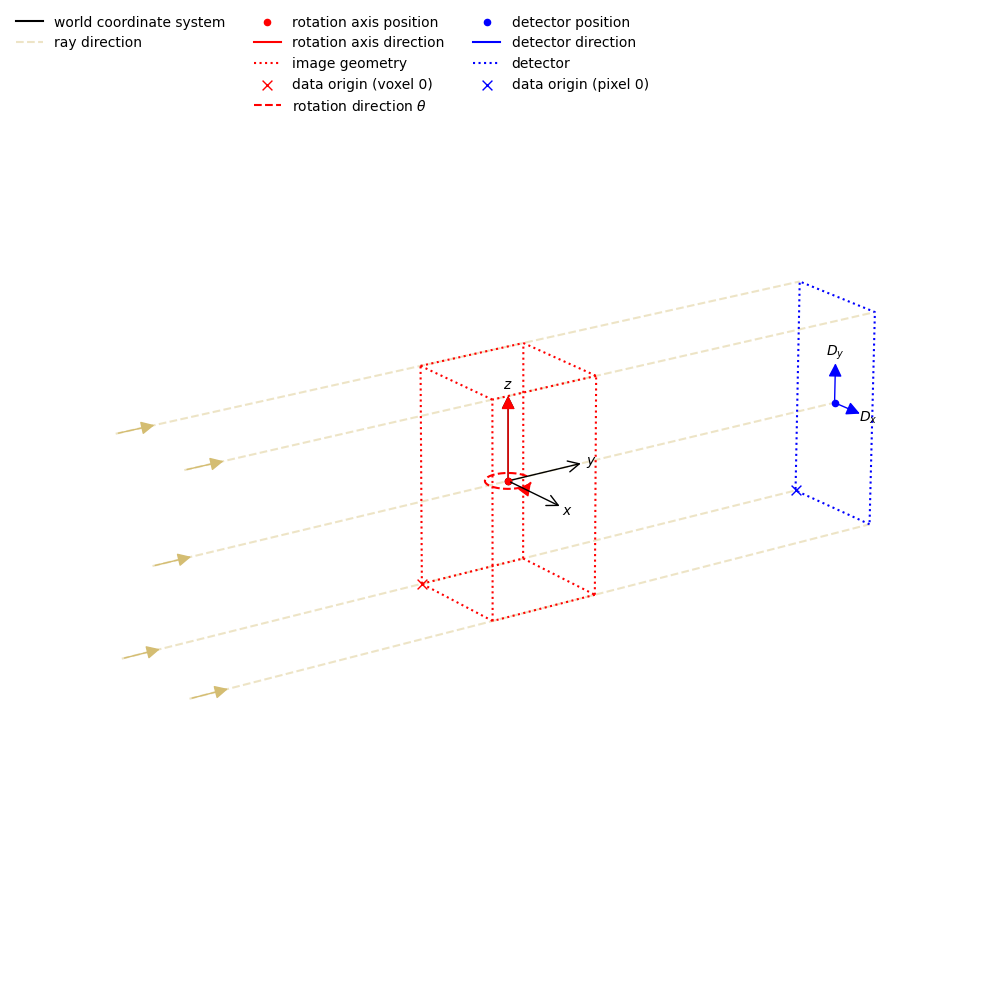

In [7]:
show_geometry(data.geometry)

##### Normalise

The uneven background suggests the data needs to be normalised. We use the flat and dark scans that we loaded as part of the data reader and the CIL `Normaliser` method. Here we have multiple flat and dark scans so we take the mean along the first axis of each. To learn more about the parameters for `Normaliser`, check CIL's documentation https://tomographicimaging.github.io/CIL/v24.3.0/processors/#data-normaliser.

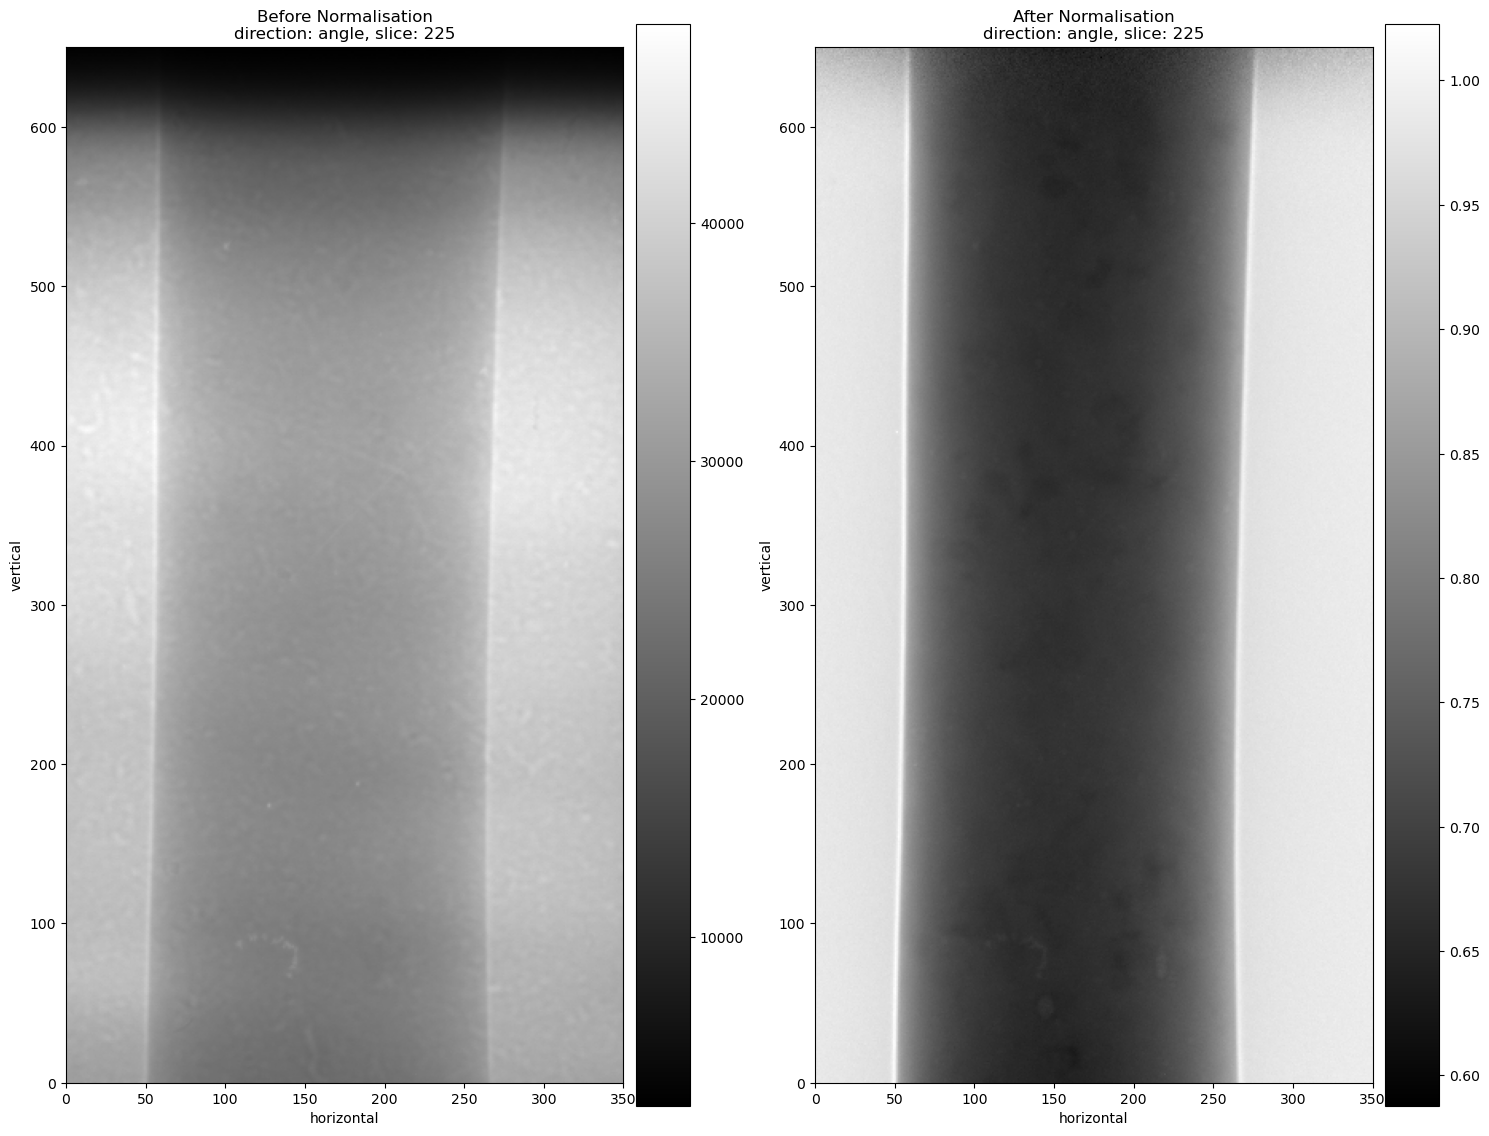

In [8]:
processor = Normaliser(flat_field=np.mean(reader.flatfield.array, axis = 0), dark_field=np.mean(reader.darkfield.array, axis = 0))
processor.set_input(data)
data_test = processor.get_output()

# Use the show2D method to check the effect of the normalisation
show2D([data, data_test],
       title=['Before Normalisation', 'After Normalisation'])

Look at the sinogram for a detector row, here we select vertical index=460

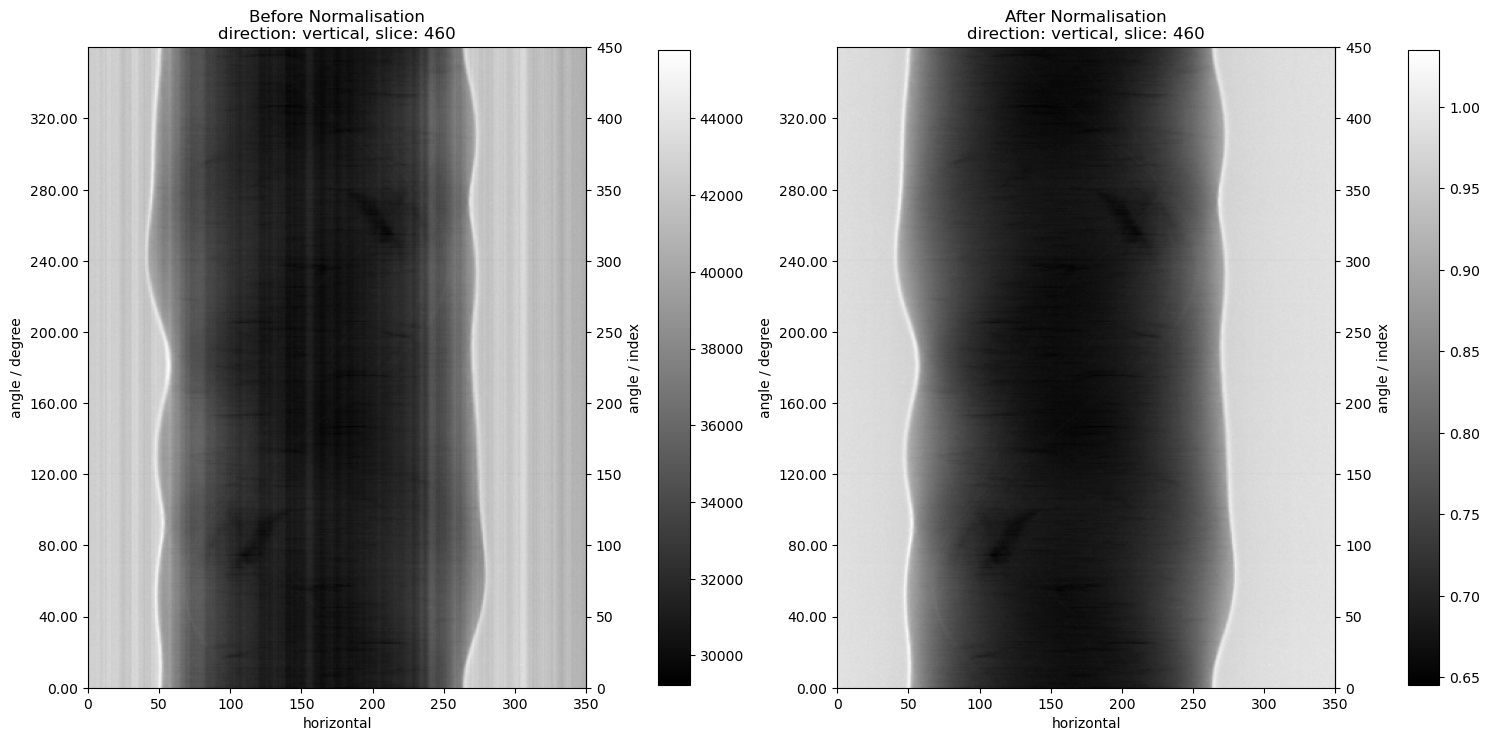

In [9]:
vertical_slice = 460
show2D([data, data_test], slice_list=('vertical', vertical_slice),
       title=['Before Normalisation', 'After Normalisation'])

If we're happy with the outcome of the processor, copy the results from data_test

In [10]:
data = data_test.copy()

##### Transmission to absorption 

Next we use the CIL `TransmissionAbsorptionConverter` which applies the Beer-Lambert law, to view the data in the absorption domain. If there are negative numbers in the data, specify a low value in `min_intensity` to clip these values before calculating $-log()$, check CIL's documentation for more details about configuring this processor https://tomographicimaging.github.io/CIL/v24.3.0/processors/#transmission-to-absorption-converter

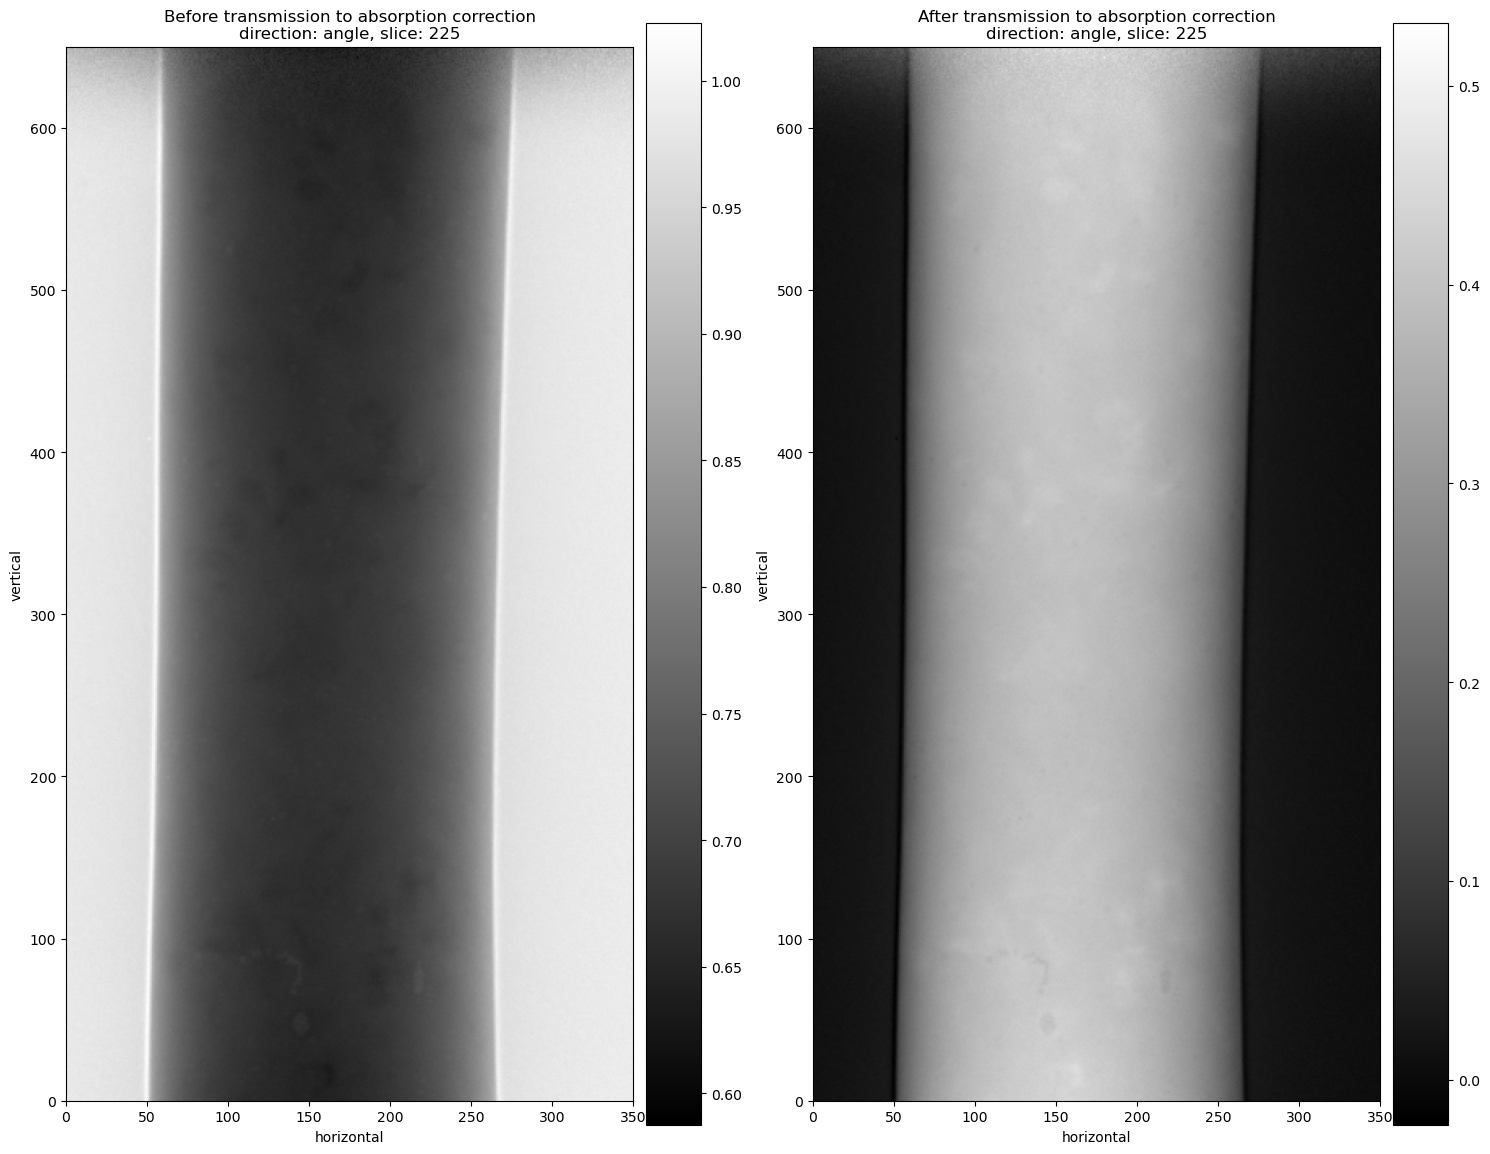

In [11]:
data_test = TransmissionAbsorptionConverter()(data)
show2D([data, data_test], ['Before transmission to absorption correction','After transmission to absorption correction'])


In [12]:
data = data_test.copy() # copy the data if we're happy with the processor

##### Filtered back projection

Next we use the CIL Filtered Back Projection `FBP` method to check the reconstruction on a single vertical slice of the data. The FBP method in the recon class uses `tigre` by default but can alternatively be configured for use with the  `backend = astra`. These use projectors from the tigre and astra packages respectively, see CIL's documentation for more details https://tomographicimaging.github.io/CIL/v24.3.0/recon/#fbp-reconstructor-for-parallel-beam-geometry.

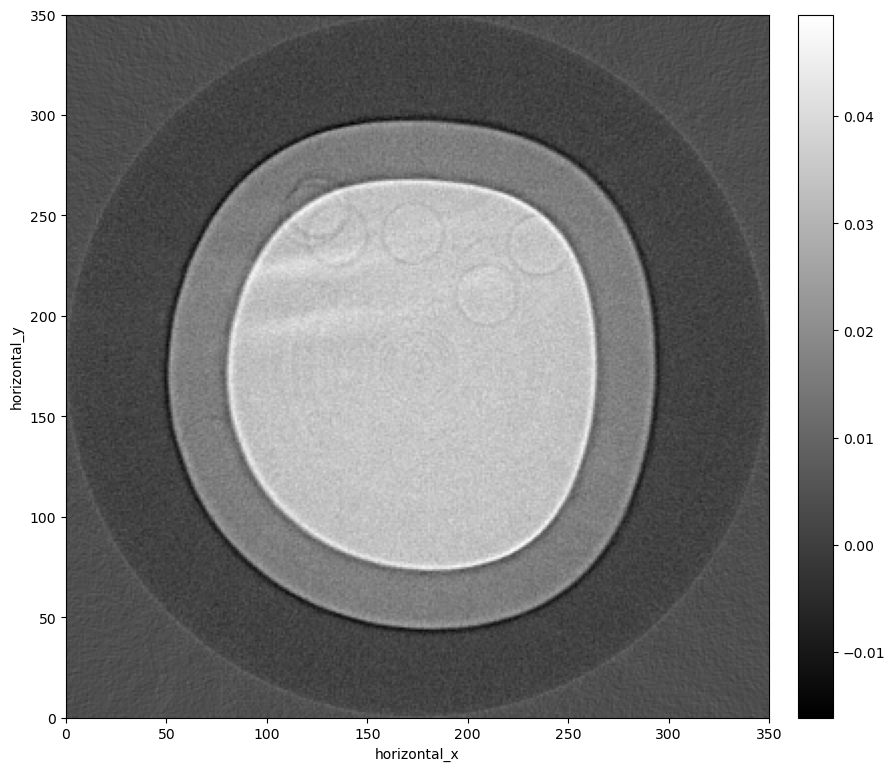

In [13]:
data_slice = data.get_slice(vertical=vertical_slice)
reco = FBP(data_slice).run(verbose=False)
show2D(reco)

##### Centre of rotation correction

Various artefacts can be observed in the reconstruction if the sample is not perfectly at the centre of the rotation stage. This dataset is from a parallel beam experiment and it has projections from 360 degrees around the sample, which results in a doubling effect if the centre of rotation is offset. We can remove the artefacts by accounting for the offset in the reconstruction. 

We can find the correct offset by looping through different pixel values manually and view the reconstructions using `islicer` to choose the offset where rotation artefacts are minimised. Run the cell below and vary the slice index to see the effect of using different pixel offsets.

In [14]:
array_list = []
pixel_offsets = [-10, -15, -20, -25]
for p in pixel_offsets:
    data_test.geometry.set_centre_of_rotation(p, distance_units='pixels')
    data_slice = data_test.get_slice(vertical=vertical_slice)
    reco_test = FBP(data_slice).run(verbose=False)
    array_list.append(reco_test.array)
DC = DataContainer(np.stack(array_list, axis=0), dimension_labels=tuple(['Centre of rotation offset']) + reco_test.geometry.dimension_labels)
islicer(DC, title=tuple(['Centre of rotation offset: ' + str(p)  + ', index: ' for p in pixel_offsets]))

Alternatively, there are two methods in CIL which can automatically identify the correct centre of rotation
- The CIL `CentreOfRotationCorrector.xcorrelation` processor finds the centre of rotation offset automatically by comparing a single slice of projections 180 degrees apart and minimising the difference between them. It can be used on parallel beam data.
- Here we use the `CentreOfRotationCorrector.image_sharpness` processor which maximises the sharpness of a reconstructed slice. It can be used on single slice parallel-beam, and centre-slice of cone-beam geometry with 360 degrees of data.
Check CIL's documentation for details of the methods for correcting the centre of rotation https://tomographicimaging.github.io/CIL/v24.3.0/processors/#centre-of-rotation-corrector

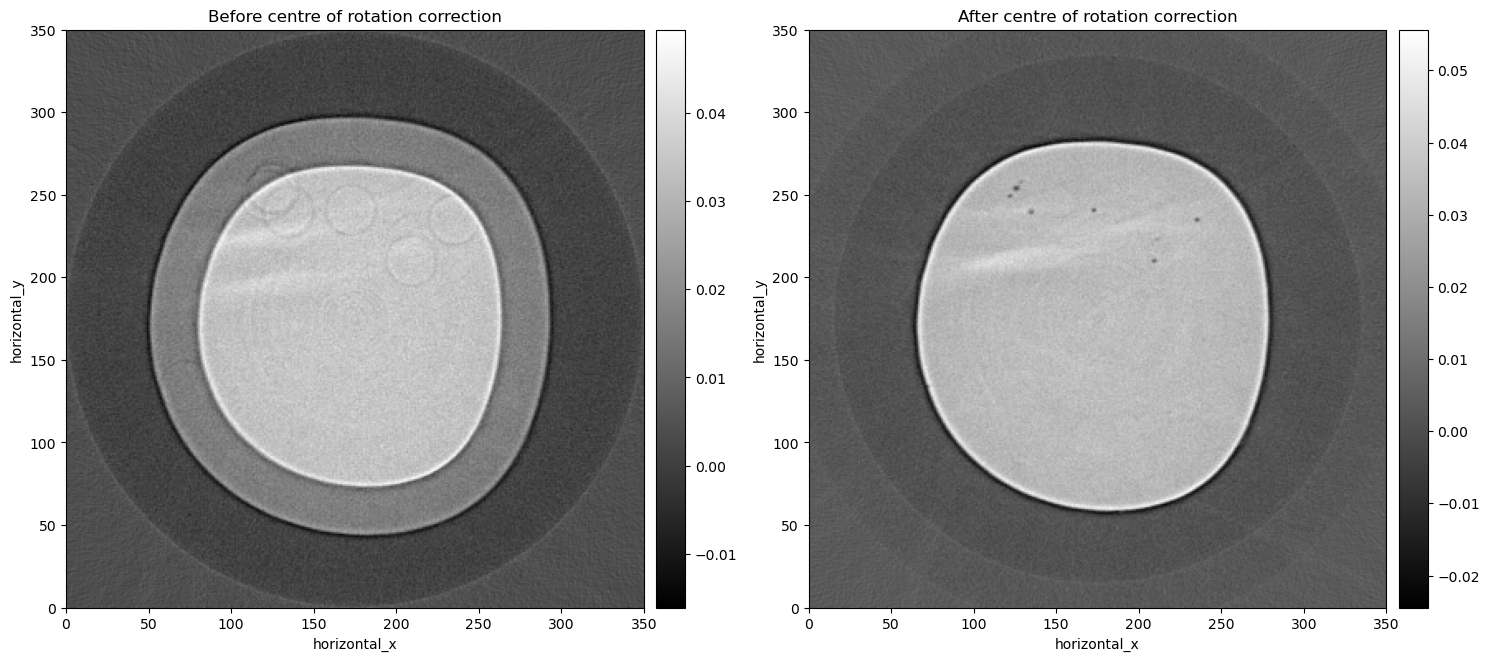

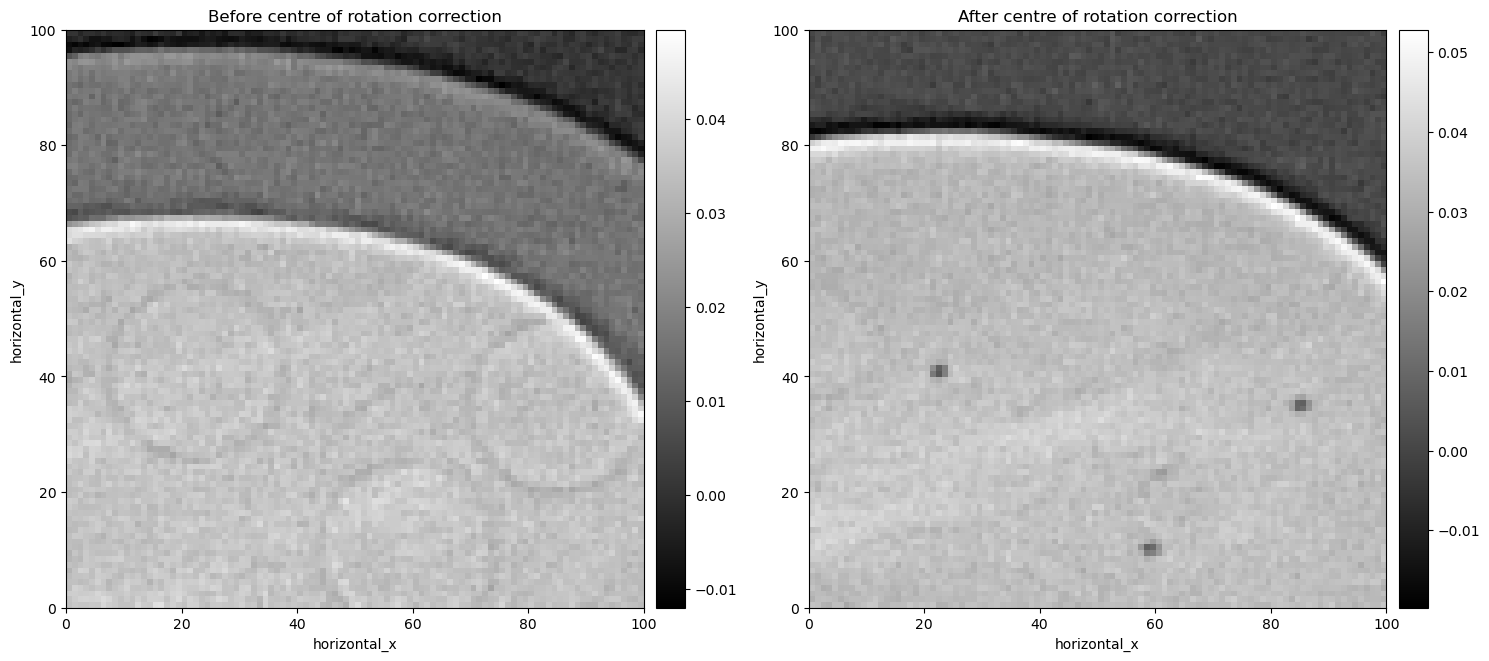

In [15]:
data_test = CentreOfRotationCorrector.image_sharpness()(data)

# Check the effect on the reconstruction
data_slice = data_test.get_slice(vertical=vertical_slice)
reco_test = FBP(data_slice).run(verbose=False)
show2D([reco, reco_test],
['Before centre of rotation correction','After centre of rotation correction'])
# And a zoomed in plot of the slice
show2D([reco.array[200:300,150:250], reco_test.array[200:300, 150:250]],
       title=['Before centre of rotation correction','After centre of rotation correction'],
       axis_labels=('horizontal_x', 'horizontal_y'))

Print the geometry to see the rotation axis has been changed

In [16]:
print("Centre of rotation before {}"
      .format(data.geometry.get_centre_of_rotation(distance_units='pixels')))
print("Centre of rotation after {}"
      .format(data_test.geometry.get_centre_of_rotation(distance_units='pixels')))

Centre of rotation before {'offset': (0.0, 'pixels'), 'angle': (0.0, 'radian')}
Centre of rotation after {'offset': (-14.585286043828182, 'pixels'), 'angle': (0.0, 'radian')}


In [17]:
data = data_test.copy() # copy the data if we're happy with the processor
reco = reco_test.copy() # copy the reconstruction if we're happy with the processor

##### Ring removal

Ring artefacts appear in the reconstruction where dead or varying pixels remain in the projections. Various methods exist to remove these from the reconstruction. Here we use the CIL `RingRemover` which removes stripes in the sinogram via a wavelet decomposition method. Try varying different parameters on a vertical slice of the dataset and see the effect on the rings in the reconstruction (for slice 460 there is a small ring at the centre of the reconstruction)
- The `decNum` parameter defines the number of wavelet decompositions used. Increasing decNum will increase the ring remover strength, but increases the computational effort and may distort the shape of the data.
- `wname` defines the filter name to use from `'db1' -- 'db35', 'haar'` - increasing the wavelet filter number increases the strength of the ring removal, but also increases the computational effort
- `sigma` describes the damping parameter in Fourier space - increasing sigma, increases the size of artefacts which can be removed

Find more details about the ring remover method here https://tomographicimaging.github.io/CIL/v24.3.0/processors/#ring-remover

In [18]:
array_list = []
array_list.append(reco.array) # include the original reconstruction for comparison
sigma = 0.01
wname = "db5"
decNum_list = [1, 2, 3, 4]
for d in decNum_list:
    data_slice = data_test.get_slice(vertical=vertical_slice)
    data_slice = RingRemover(decNum = d, wname = wname, sigma = sigma,  info = False)(data_slice)
    reco_test = FBP(data_slice).run(verbose=False)
    array_list.append(reco_test.array)
DC = DataContainer(np.stack(array_list, axis=0), dimension_labels=tuple(['Ring remover decNum']) + reco.geometry.dimension_labels)
islicer(DC, title=tuple(['No ring remover'] + ['Ring remover decNum: ' + str(p) + ', index: ' for p in decNum_list]))

We conclude that using small parameters (e.g. `sigma=0.01, wname="db5"` and `decNum=1`) gives the most effective the ring removal without introducing new artefacts, so we apply this method to the whole dataset

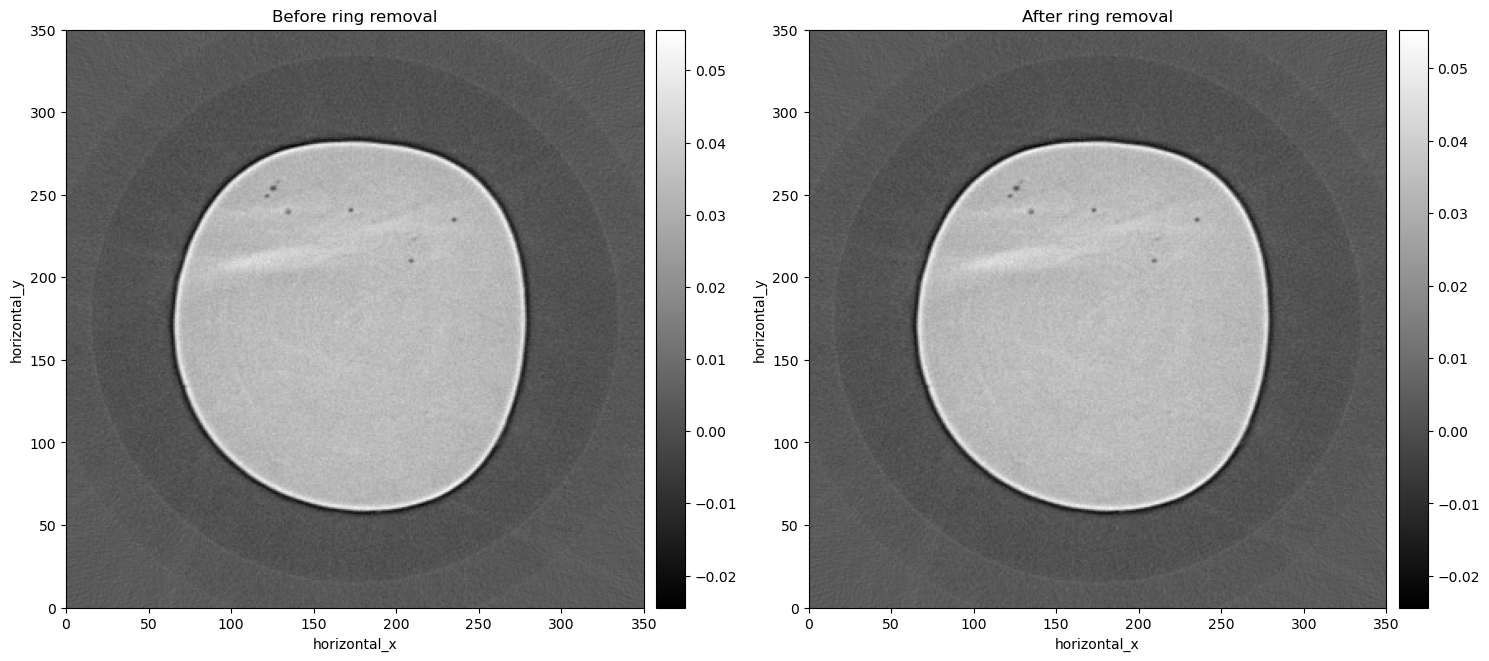

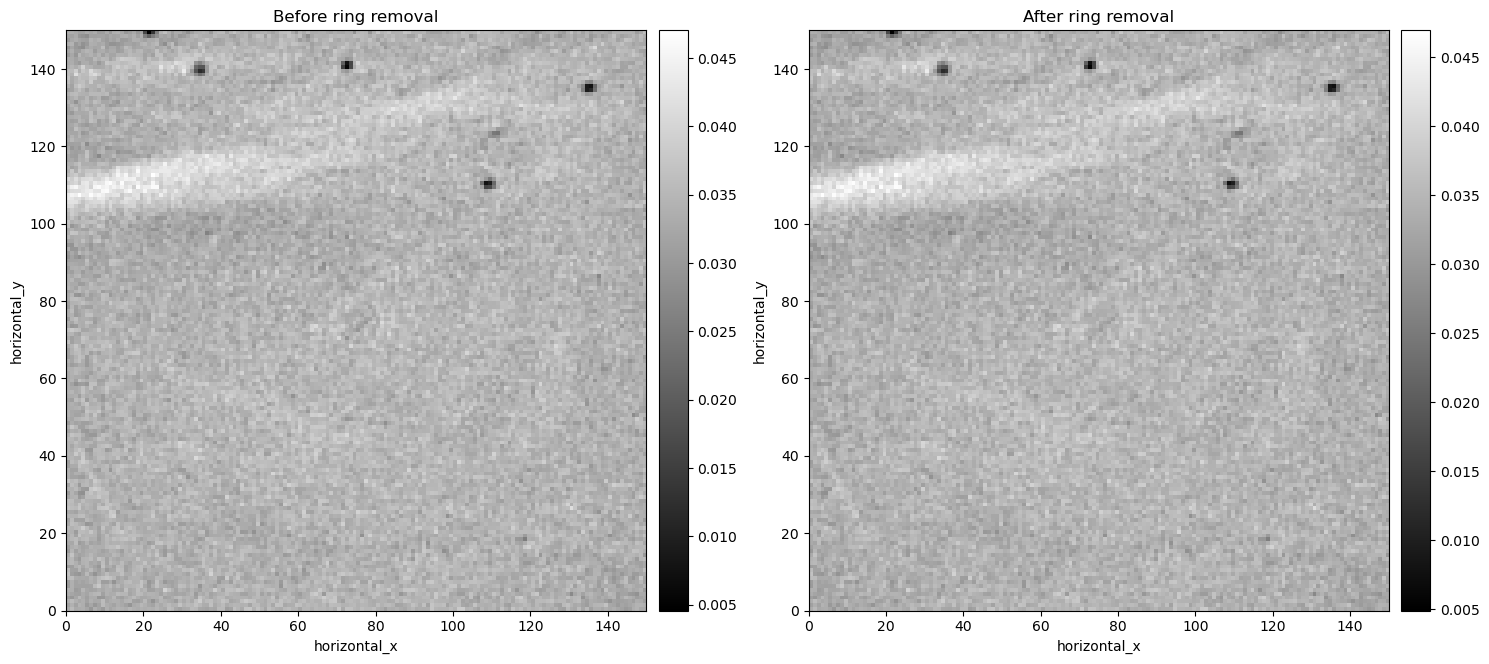

In [19]:
sigma = 0.01
wname = "db5"
decNum = 1
data_test = RingRemover(decNum = decNum, wname = wname, sigma = sigma,  info = False)(data)

# Compare a slice of the reconstruction
data_slice = data_test.get_slice(vertical=vertical_slice)
reco_test = FBP(data_slice).run(verbose=False)
show2D([reco, reco_test],
       title=["Before ring removal", "After ring removal"])
# And a zoomed in plot of the slice
show2D([reco.array[100:250, 100:250], reco_test.array[100:250,100:250]],
       title=["Before ring removal", "After ring removal"],
       axis_labels=('horizontal_x', 'horizontal_y'))

In [20]:
data = data_test.copy() # copy the data if we're happy with the processor
reco = reco_test.copy() # copy the reconstruction if we're happy with the processor

##### Phase retrieval

The bright edges in the reconstruction are an example of edge enhancement due to phase contrast. In this experiment, propagation-based phase contrast imaging was used to exploit the different contrast provided by absorption and phase. Phase retrieval methods can be used to separate out the phase and intensity information. CIL implements the common Paganin phase retrieval method (see [https://doi.org/10.1046/j.1365-2818.2002.01010.x](https://onlinelibrary.wiley.com/doi/10.1046/j.1365-2818.2002.01010.x)) which results in a boost to the signal to noise ratio (SNR) without losing spatial resolution and so is a commonly used pre-processing step, however, it can result in blurring out useful features so should be used with care!

Run the CIL `PaganinProcessor`
- `delta` and `beta` are the real and complex part of the material refractive index. Increasing the ratio of `delta/beta` increases the strength of the filter, here we've chosen the parameters to remove fringes. Try varying the strength to see the effect on the reconstruction.
- `full_retrieval = False` means the calculation does not include $-log()$. If we apply the phase retrieval before converting to absorption we should use `full_retrieval = True`

For more information about using the `PaganinProcessor` in CIL, check the documentation https://tomographicimaging.github.io/CIL/v24.3.0/processors/#paganin-processor or for a more detailed explanation of the effect of different parameters, see the phase retrieval demo in the deep dive folder [demos/4_Deep_Dives/02_phase_retrieval.ipynb](https://github.com/TomographicImaging/CIL-Demos/blob/main/demos/4_Deep_Dives/02_phase_retrieval.ipynb).

  0%|          | 0/450 [00:00<?, ?it/s]

  4%|▍         | 17/450 [00:00<00:02, 161.99it/s]

  8%|▊         | 34/450 [00:00<00:02, 158.92it/s]

 11%|█▏        | 51/450 [00:00<00:02, 161.52it/s]

 16%|█▌        | 70/450 [00:00<00:02, 169.33it/s]

 20%|█▉        | 89/450 [00:00<00:02, 174.09it/s]

 24%|██▍       | 108/450 [00:00<00:01, 176.42it/s]

 28%|██▊       | 126/450 [00:00<00:01, 176.89it/s]

 32%|███▏      | 144/450 [00:00<00:01, 177.78it/s]

 36%|███▌      | 163/450 [00:00<00:01, 179.06it/s]

 40%|████      | 182/450 [00:01<00:01, 180.38it/s]

 45%|████▍     | 201/450 [00:01<00:01, 181.15it/s]

 49%|████▉     | 220/450 [00:01<00:01, 181.82it/s]

 53%|█████▎    | 239/450 [00:01<00:01, 182.03it/s]

 57%|█████▋    | 258/450 [00:01<00:01, 182.90it/s]

 62%|██████▏   | 277/450 [00:01<00:00, 183.38it/s]

 66%|██████▌   | 296/450 [00:01<00:00, 183.64it/s]

 70%|███████   | 315/450 [00:01<00:00, 183.48it/s]

 74%|███████▍  | 334/450 [00:01<00:00, 184.14it/s]

 78%|███████▊  | 353/450 [00:01<00:00, 183.92it/s]

 83%|████████▎ | 372/450 [00:02<00:00, 183.80it/s]

 87%|████████▋ | 391/450 [00:02<00:00, 183.77it/s]

 91%|█████████ | 410/450 [00:02<00:00, 183.53it/s]

 95%|█████████▌| 429/450 [00:02<00:00, 183.27it/s]

100%|█████████▉| 448/450 [00:02<00:00, 181.79it/s]

100%|██████████| 450/450 [00:02<00:00, 179.67it/s]

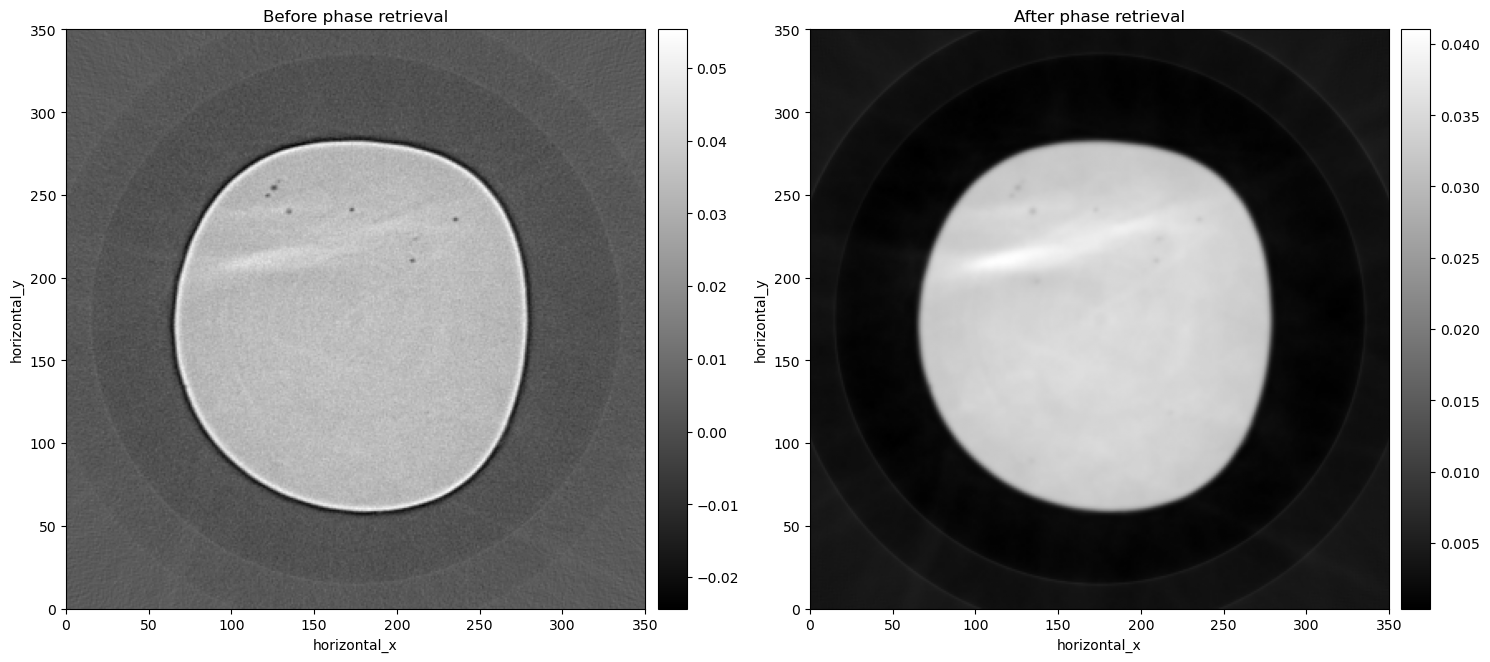

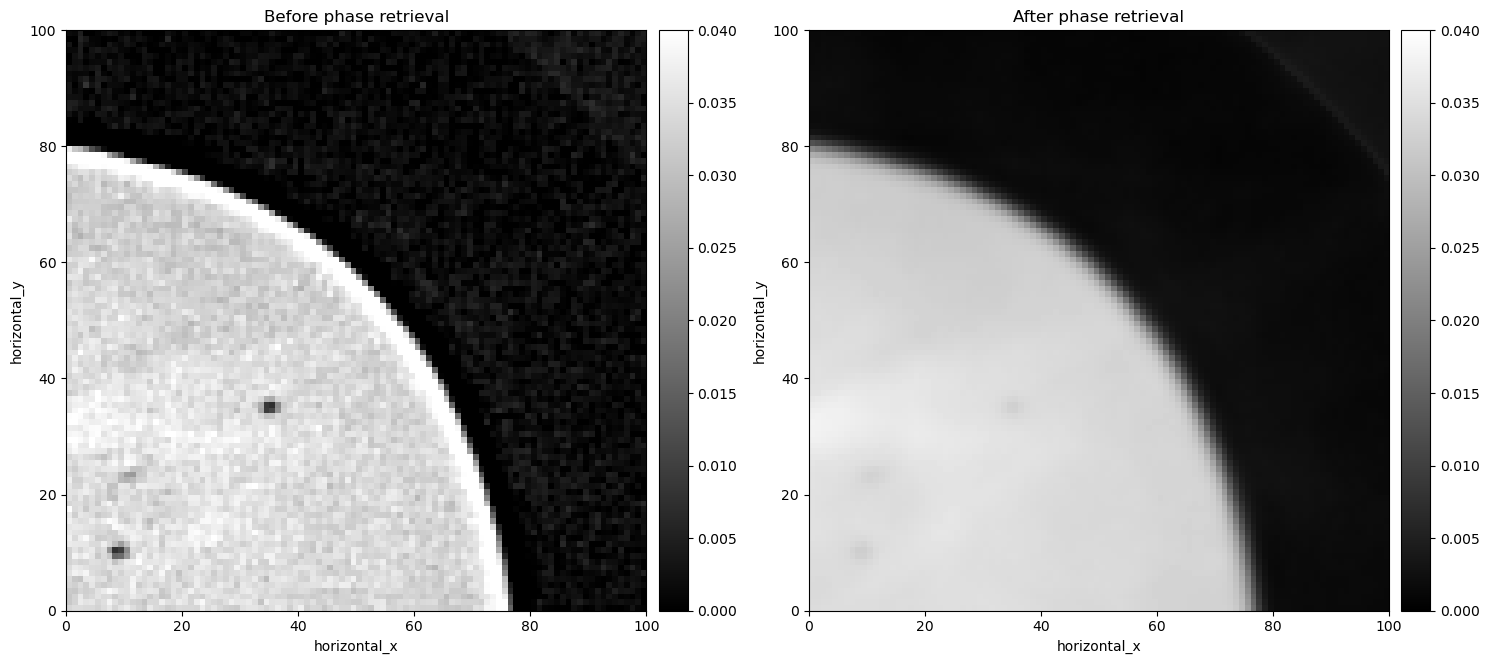

In [21]:
delta = 3e-5
beta = 2e-10
processor = PaganinProcessor(delta=delta, beta=beta, 
                             energy=energy, energy_units='keV', 
                             full_retrieval=False)
processor.set_input(data)
data_test = processor.get_output()

# Compare a zoomed-in slice of the reconstruction
data_slice = data_test.get_slice(vertical=vertical_slice)
reco_test = FBP(data_slice).run(verbose=False)

show2D([reco, reco_test],
       ["Before phase retrieval", "After phase retrieval"])
show2D([reco.array[200:300, 200:300], reco_test.array[200:300, 200:300]],
       title=["Before phase retrieval", "After phase retrieval"],
       fix_range=(0.00, 0.04),
       axis_labels=('horizontal_x', 'horizontal_y'))

We can see that the bright contrast at the edge is reduced, sample features are blurred and noise is reduced. Plot a cross-section through the edge of the sample to look more closely at the fringes caused by the phase contrast. We can see a sharp peak/ fringe at the sample edge in the reconstruction before the phase retrieval and after phase retrieval the fringe is removed. The sample feature (at horizontal_x, horizontal_y=35 in the plot above) is reduced in intensity and blurred but we find the SNR of the feature is improved. 

It's important to note that phase retrieval might be useful if the improved SNR is important, or to maintain the precise shape of sample features - for example in metrology. However, it should be used with caution if you want to exploit the advantages of phase contrast - for example using edge enhancement to aid segmentation. You should consider carefully whether the phase retrieval step should be used on each dataset.

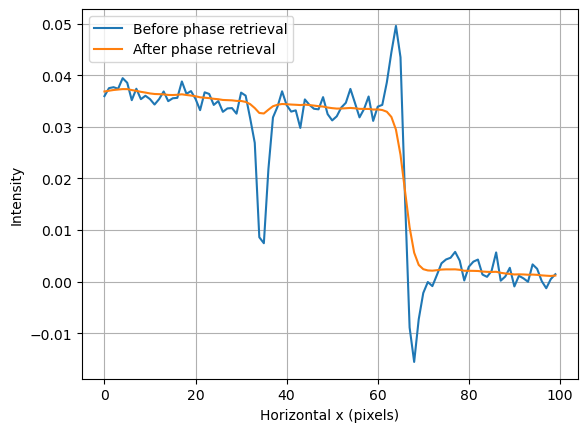

In [22]:
plt.plot(reco.array[235,200:300])
plt.plot(reco_test.array[235,200:300])
plt.grid()
plt.xlabel('Horizontal x (pixels)')
plt.ylabel('Intensity')
plt.legend(['Before phase retrieval','After phase retrieval'])

In [23]:
print("Original reconstruction SNR = {:.3f}".format(np.abs(reco.mean()/reco.array.std())))
print("Phase retrieved reconstruction SNR = {:.3f}".format(np.abs(reco_test.mean()/reco_test.array.std())))

Original reconstruction SNR = 0.809
Phase retrieved reconstruction SNR = 0.853


In [24]:
y = reco.array[235,210:260]
print("Sample feature SNR = {:.3f}".format(np.abs(y.mean()/y.std())))
y = reco_test.array[235,210:260]
print("Sample feature SNR after phase retrieval = {:.3f}".format(np.abs(y.mean()/y.std())))

Sample feature SNR = 5.711
Sample feature SNR after phase retrieval = 31.727


In [25]:
data = data_test.copy() # copy the data if we're happy with the processor
reco = reco_test.copy() # copy the reconstruction if we're happy with the processor

##### The final reconstruction

Reconstruct the whole dataset then view the reconstruction in `islicer`. 

Try exploring the data and adjusting the display settings.

Notice how some of the processor parameters we configured for the single slice might need to be edited when applied to the full dataset, such as the ring remover strength. Similarly, the phase retrieval step works best for vertical slices with neighbouring slices that contain similar materials, therefore we notice artefacts in the first and last vertical slice.

In [26]:
reco = FBP(data).run(verbose=False)

In [27]:
islicer(reco)

##### Save the processed data

Once we're happy with the reconstruction save the processed data as TIFF files

In [28]:
writer = TIFFWriter()
writer.set_up(data = data, file_name='path_to_data/data.tiff')
# writer.write() # uncomment to save the reconstruction